In [1]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import time
import numpy as np
import tensorflow as tf
import skimage.transform
from src.model import Model
from src.data_loader import dataLoader
import matplotlib.pyplot as plt

In [2]:
import matplotlib.patches as patches

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [4]:
# Change if needed
n_iters     = 10
print_every = 5
batch_size  = 1
pretrained_model = './model/lstm1/model-50'
ground_attention_upsample = (64, 64)

In [5]:
# Load train dataset
data = dataLoader(directory='./dataset', dataset_dir='test_curated', dataset_name='test.txt', max_steps=3, mode='Test')
# Load Model
model = Model(dim_feature=[49, 128], dim_hidden=128, n_time_step=3,
              alpha_c=1.0, image_height=64, image_width=64, mode='test')
# Build model for inference
pred_bboxs_, alpha_list_ = model.build_test_model()

CNN build model sucess!


In [7]:
## Run FeedForward

# Collect predictions from runs for viz
vis_images  = []
attn_images = []
pred_bboxes = []
grnd_bboxes = []

# Test Data Loader
test_gen = data.gen_data_batch(batch_size)

# Set GPU options
config = tf.GPUOptions(allow_growth=True)

with tf.Session(config=tf.ConfigProto(gpu_options=config)) as sess:
    # Intialize the training graph
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

    if pretrained_model is not None:
        print("Start testing with pretrained Model..")
        saver.restore(sess, pretrained_model)
    else:
        print("Start testing with Model with random weights...")

    for i in range(n_iters):
        image_batch, grd_bboxes_batch, _= next(test_gen)
        feed_dict = {model.images: image_batch,
                     model.drop_prob: 1.0}
        prediction_bboxes, prediction_alpha = sess.run([pred_bboxs_, alpha_list_], feed_dict)
        
        vis_images.append(image_batch)
        attn_images.append(prediction_alpha)
        pred_bboxes.append(prediction_bboxes)
        grnd_bboxes.append(grd_bboxes_batch)
        
        if i%print_every == 0:
            print('Inference Completion..{%d/%d}' % (i, n_iters))
    #-----------------------------------------------------
    print('Inference Completion..{%d/%d}' % (n_iters, n_iters))
    print('Completed!')
# Close session
sess.close()

Start testing with pretrained Model..
INFO:tensorflow:Restoring parameters from ./model/lstm1/model-50
Inference Completion..{0/10}
Inference Completion..{5/10}
Inference Completion..{10/10}
Completed!


In [8]:
print(len(vis_images))
print(len(attn_images))
print(len(pred_bboxes))
print(len(grnd_bboxes))

10
10
10
10


In [9]:
grnd_bboxes[0][0][0]

array([21.,  9., 20., 40.])

In [12]:
## Upscale attention mask
upscaled_attn_images = []
for k in range(len(attn_images)):
    sample_attention_res_interm = []
    for K in range(3):
        sample_attention_res = skimage.transform.pyramid_expand(attn_images[k][K][0][:, :, 0], upscale=9.1, sigma=1)
        sample_attention_res_interm.append(sample_attention_res)
    
    upscaled_attn_images.append(sample_attention_res_interm)

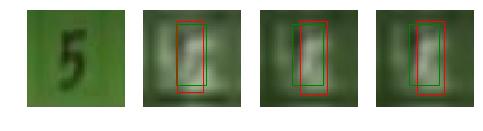

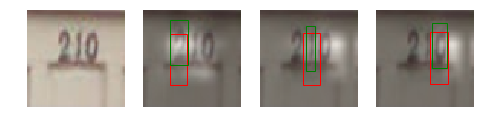

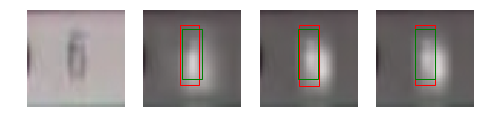

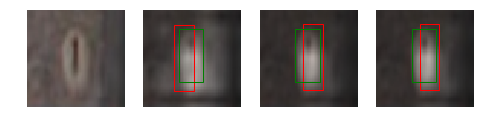

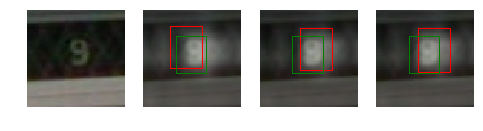

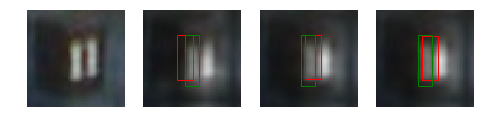

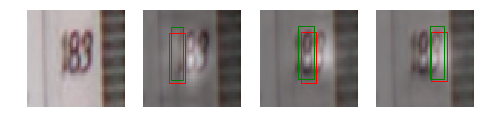

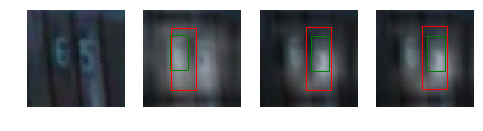

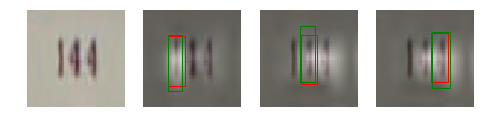

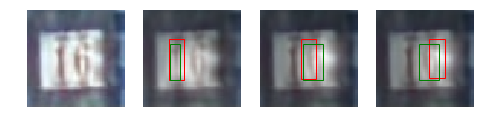

In [13]:
for t in range(10):
    # Plot original image
    fig,ax = plt.subplots(1, 4)
    ax[0].imshow(vis_images[t][0])
    ax[0].axis('off')
    for T in range(3):
        ax[T+1].imshow(vis_images[t][0])
        ax[T+1].imshow(upscaled_attn_images[t][T], alpha=0.5)
        sample_left  = pred_bboxes[t][T][0][0]
        sample_top   = pred_bboxes[t][T][0][1]
        sample_width = pred_bboxes[t][T][0][2]
        sample_heigt = pred_bboxes[t][T][0][3]

        sample_left_grd  = grnd_bboxes[t][0][T][0]
        sample_top_grd   = grnd_bboxes[t][0][T][1]
        sample_width_grd = grnd_bboxes[t][0][T][2]
        sample_heigt_grd = grnd_bboxes[t][0][T][3]
        
        rect1 = patches.Rectangle((sample_left, sample_top), sample_width, sample_heigt,linewidth=1,edgecolor='r',facecolor='none')  
        rect2 = patches.Rectangle((sample_left_grd, sample_top_grd), sample_width_grd, sample_heigt_grd,linewidth=1,edgecolor='g',facecolor='none')  

        ax[T+1].add_patch(rect1)
        ax[T+1].add_patch(rect2)
        ax[T+1].axis('off')
    
    plt.show()